Early Stages of the file. Working on basic word analysis

In [342]:
import requests
from lxml import etree
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import re
import unicodedata
import warnings

In [343]:
sns.set(rc={'figure.figsize':(10,8)})

In [344]:
import nltk
nltk.download(["names", "stopwords","averaged_perceptron_tagger",
               "punkt", "vader_lexicon", "wordnet"], quiet=True)

True

In [345]:
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# UDF

In [346]:
def make_lemma(text):
  """
  Function to lemmatize and clean text
  
  From: https://towardsdatascience.com/from-dataframe-to-n-grams-e34e29df3460
  """
  word_lemma = nltk.stem.WordNetLemmatizer()
  stopwords_ = nltk.corpus.stopwords.words('english')
  stopwords_.extend(['gizmos', 'feel', 'like', 'game', 'board', 'bit', 'get', 'reall'])
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split() 
  word_li = [word_lemma.lemmatize(word) for word in words if word not in stopwords_]

  # One last move: will replace building with builder, since there's no distinction in this case
  # This is also a very commong word in the corpus
  word_li = ['builder' if word == 'building' else word for word in word_li] 

  # For some reason, stopwords isn't removing this one. Doing so manually
  if 'game' in word_li:
    word_li.remove('game')

  return word_li

In [347]:
def dataframe_to_wordlist(df, word_col):
    all_text = ''

    for i in range(len(df)):
        new_text = df.iloc[i, word_col]
        all_text += ' ' + new_text

    all_text = all_text.encode("ascii", errors="ignore").decode()
    for symbol in ['!', ',','.','_', '(', ')']:
        all_text = all_text.replace(symbol, ' ')
    
    all_text = all_text.lower()
    return all_text.split(' ')

# Scrape Game Description

In [348]:
#con = sqlite3.connect('bgg.db')
#cur = con.cursor()

In [349]:
params = {'id' : '246192','stats' :'0'}
response = requests.get('https://www.boardgamegeek.com/xmlapi2/thing?', params)
soup = BeautifulSoup(response.text, "xml")
str_ = str(soup.find('description'))

In [350]:
str_ = str_.replace('<description>', '')
str_ = str_.replace('</description>', '')
str_

"The smartest minds of our generation are gathering together at the Great Science Fair. Everyone's been working hard on their creations, but only one will be crowned champion. Contestants have to think on the fly to build their machines quickly and efficiently. Whose project will be the best?&amp;#10;&amp;#10;In Gizmos, you win the game by gaining victory points from building engines. And engines help you get things done faster. Whoever builds the greatest machine and collects the most victory points wins!&amp;#10;&amp;#10;At the beginning of the game, you have 4 actions:&amp;#10;&amp;#10;     File : Put a card in the public to your Archive, allow you to build it later.&amp;#10;     Pick : Take one energy marble from the 3D marble dispenser, to your storage.&amp;#10;     Build : Build one machine and put it on action! You have to pay the marbles with colors corresponding to the card cost.&amp;#10;     Research : Draw some cards, and you can then File or Build one of the drawn cards. Th

In [351]:
comment_len = 1
comment_li = []
i = 1
game_id = '246192'
while comment_len > 0:
    params = {'id' : game_id,'comments' :'1', 'page' : str(i), 'pagesize' : str(100)}
    response = requests.get('https://www.boardgamegeek.com/xmlapi2/thing?', params)
    soup = BeautifulSoup(response.text, "xml")
    comments = soup.find_all('comment')
    for idx, com in enumerate(comments):
        comment_li.append((game_id, com['rating'], com['username'], com['value']))
    comment_len = len(comments)
    i += 1

In [352]:
df = pd.DataFrame(comment_li, columns = ['game_id', 'rating','user','description'])
df.shape

(1193, 4)

In [353]:
# Convert rating to a number
df.loc[df['rating'] == 'N/A', 'rating'] = np.nan
df.loc[:, 'rating'] = df.loc[:, 'rating'].astype(float)

In [354]:
unrated, high, low = df[pd.isna(df['rating'])].shape[0], df[df['rating'] >= 7].shape[0], df[df['rating'] < 7].shape[0]
print(unrated, high, low)

287 714 192


Text(0.5, 1.0, 'Cumulative Distribution of Scores')

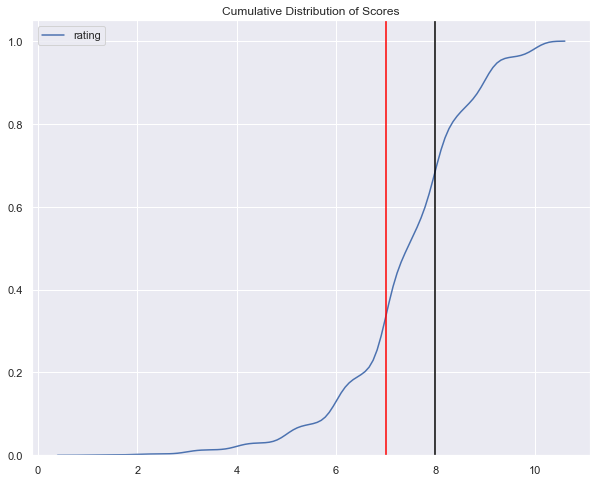

In [355]:
sns.kdeplot(df.loc[df['rating']>0, 'rating'], cumulative=True)
plt.axvline(8, 0, 1, color ='black')
plt.axvline(7, 0, 1, color ='red')
plt.title('Cumulative Distribution of Scores')

Only ~30% of scores are <= 7. Almost 70% of scores are <= 8 

In [356]:
has_rating = df[~pd.isna(df['rating'])]
has_rating.head()

,game_id,rating,user,description
1,246192,8.0,4ndrewcol3,My favorite shorter game
2,246192,6.0,Abdul,Decent but forgettable. I would have expected ...
3,246192,10.0,AbleCompany,My pick for an engine building game with just ...
4,246192,7.0,Abruptdolphin,Slimbo
5,246192,7.0,Achire,Light game. Pretty fun with all the card combo...


# NLTK Analysis

Code inspired by this site: https://realpython.com/python-nltk-sentiment-analysis/

## Let's look at phrases that appear more frequently than expected

In [357]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [358]:
from nltk.collocations import BigramCollocationFinder

finder = BigramCollocationFinder.from_words(
    dataframe_to_wordlist(has_rating, 3))

In [370]:
temp = finder.nbest(bigram_measures.pmi, 15)
print(temp)

[('"an', 'engine"'), ('"blind', 'pick"'), ('"current', 'favorite"'), ('"engine', 'builder"'), ('"gizmos', 'market"'), ('"go', 'off"'), ('"good', 'splendor"'), ('"heavy', 'filler"'), ('"karciany"', 'przynoszcy'), ('"lost', 'designs"'), ('"next', 'step"'), ('"pick', 'up"'), ('"played', 'out"'), ('"z', 'kulkami"'), ('$', 'shipping')]


Gizmos is an engine bulding game, so it's not surpise that two of the top three results mention engine building. "Go off" probably also refers to the process of engine building. Splendor is arguably the most popular engine building game, so its no surprise to see a phrase listing it.

"Blind pick" refers to a mechanic of the game: players may get to select a random resource from the main component. "Pick up" might also refer to this mechanic

Others of note: "Lost designs" refers to a mini-exapnsion for the game. "Next step" refers to games that are a bit more complicated than intro games (e.g. Ticket to Ride) but aren't quite medium-weight games (e.g. Castles of Burgundy). "Heavy filler" is another way to explain a "next step" game. "Played out" probably refers to a game's lack of originality, while "current favorite" is self explanatory. There's also a Polish phrase in there, according to Google translate it means "card fetch." 

In [360]:
has_rating.loc[:,'lemma'] = has_rating['description'].apply(make_lemma)

In [361]:
has_rating.head()

,game_id,rating,user,description,lemma
1,246192,8.0,4ndrewcol3,My favorite shorter game,"[favorite, shorter]"
2,246192,6.0,Abdul,Decent but forgettable. I would have expected ...,"[decent, forgettable, would, expected, least, ..."
3,246192,10.0,AbleCompany,My pick for an engine building game with just ...,"[pick, engine, builder, right, kind, theming, ..."
4,246192,7.0,Abruptdolphin,Slimbo,[slimbo]
5,246192,7.0,Achire,Light game. Pretty fun with all the card combo...,"[light, pretty, fun, card, combo, mechanic, lo..."


In [362]:
all_text_li = []

for i in range(len(has_rating)):
    all_text_li.extend(has_rating.iloc[i, 4])

In [363]:
(pd.Series(nltk.ngrams(all_text_li, 2)).value_counts())[:10]

(engine, builder)      334
(marble, dispenser)     54
(potion, explosion)     37
(spice, road)           25
(little, engine)        24
(century, spice)        24
(chain, reaction)       24
(splendor, century)     19
(good, engine)          18
(fun, engine)           17
dtype: int64

It seems like it's quite common for reviews to note that Gizmos is an engine building game. Most the results note this. 

People also like to compare it to other engine building games: Century Spice Road (which takes up two slots alone, three total), Potion Explosion (which takes up one spot), and Splendor (which shares a spot with century).

People also enjoy the marble dispenser, which is the game's most remarkable component.

In [369]:
(pd.Series(nltk.ngrams(all_text_li, 3)).value_counts())[:10]

(little, engine, builder)     22
(century, spice, road)        22
(fun, engine, builder)        15
(good, engine, builder)       15
(pure, engine, builder)       14
(great, engine, builder)      12
(splendor, century, spice)    10
(engine, builder, great)       9
(engine, builder, good)        9
(light, engine, builder)       8
dtype: int64

Nothing remarkable here. It's an engine building game like Splendor and Century.

In [365]:
wordfreq = {}

for token in all_text_li:
    if len(token) >= 3:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

In [367]:
import heapq
most_freq = heapq.nlargest(20, wordfreq, key=wordfreq.get)
print(most_freq)

['engine', 'builder', 'marble', 'play', 'card', 'fun', 'splendor', 'good', 'one', 'combo', 'really', 'player', 'great', 'dispenser', 'build', 'action', 'would', 'little', 'turn', 'time']
